In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
import emm
import warnings
warnings.filterwarnings('ignore')

# Plot styles
plt.style.use('seaborn-notebook')

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# Generate example data
m = 5000
# Target distribution
mu0 = np.array([115]); sig0 = np.array([10])
mu1 = np.array([135]); sig1 = np.array([15])
X0 = np.random.normal(loc=mu0, scale=sig0, size=m // 2)
X1 = np.random.normal(loc=mu1, scale=sig1, size=m // 2)
y0 = np.zeros(m // 2)
y1 = np.ones(m // 2)
X = np.concatenate([X0,X1])
y = np.concatenate([y0,y1])

target = pd.DataFrame({'feature' : X})
target['Outcome'] = y

# Corpus distribution
mu = np.array([125]); sig = np.array([15])
corpus = np.random.normal(loc=mu, scale=sig, size=m)
corpus = pd.DataFrame({'feature': corpus})

In [15]:
histLoss0 = emm.losses.CorpusKLLoss(mean=100)
histLoss1 = emm.losses.CorpusKLLoss(mean=150)
lam = 1
margsKL = {
            0 : {
                     'feature' : {'fun' : [histLoss0.fun], 'loss' : [histLoss0]},
                 'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                                  'lam' : lam}
                },
            1 : {
                     'feature' : {'fun' : [histLoss1.fun], 'loss' : [histLoss1]},
                 'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                                  'lam' : lam}
                }
          }
                              
margsLS = {
            0 : {
                     'feature' : {'fun' : ['mean'], 'loss' : [emm.losses.LeastSquaresLoss(100)]},
                 'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                                  'lam' : lam}
                                  
                },
            1 : {
                     'feature' :  {'fun' : ['mean'], 'loss' : [emm.losses.LeastSquaresLoss(150)]},
                 'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                                  'lam' : lam}
                }
           }
    
margsEq = {
            0 : {
                     'feature' : {'fun' : ['mean'], 'loss' : [emm.losses.EqualityLoss(100)]},
                 'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                                  'lam' : lam}
                },
            1 : {
                     'feature' :  {'fun' : ['mean'], 'loss' : [emm.losses.EqualityLoss(150)]},
                 'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                                  'lam' : lam}
                }
           }
    

    
margs = [margsKL, margsLS, margsEq]

from sklearn.linear_model import LogisticRegression
param_grid_log =  {"classifier" : [LogisticRegression()],
                 "classifier__C": np.logspace(-3,3,7), 
                   "classifier__penalty":["l1","l2"]}
from sklearn.tree import DecisionTreeClassifier
param_grid_tree =  {'classifier' : [DecisionTreeClassifier()],
     'classifier__max_depth' : [2,4,6,7,9]}
param_grid = [param_grid_log, param_grid_tree]
   
(rwcs, js, scores) = emm.metrics.multiple_models(target,corpus,margs, 
                                        param_grid, verbose=True)

CVX took 1.67474 seconds
CVX took 0.97453 seconds
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Target data: the best parameters are given by 
 LogisticRegression(C=0.001)
 the best mean cross-validation accuracy 81.775 +/- 0.52082% on training dataset 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Target data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=4)
 the best mean cross-validation accuracy 81.05 +/- 0.72715% on training dataset 

CVX took 0.62285 seconds
CVX took 0.59897 seconds
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Target data: the best parameters are given by 
 LogisticRegression(C=0.01)
 the best mean cross-validation accuracy 80.45 +/- 1.26145% on training dataset 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Target data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=2)
 the best mean cross-validation accuracy 81.025 +/- 0.6586% on training dataset 

CVX took 0

In [16]:
print(js)

[0.12796892754704345, 0.34890540148120885, 0.3499861483025159]


In [17]:
l = []
for d in scores:
    l += [d['accuracy_score']]
    
df = pd.DataFrame(l)
display(df)
display(df.RR/df.SR)

,RR,RS,SS,SR
0,0.797,0.798201,0.797833,0.794
1,0.818,0.792452,0.790444,0.819
2,0.843,0.952068,0.950885,0.845
3,0.809,0.949731,0.950284,0.809
4,0.816,0.953704,0.953704,0.817
5,0.796,0.952520,0.955516,0.811


0    1.003778
1    0.998779
2    0.997633
3    1.000000
4    0.998776
5    0.981504
dtype: float64

In [22]:
clf = LogisticRegression()
X = np.array(rwcs[0]['feature']).reshape(-1,1)
y = np.array(rwcs[0]['Outcome']).reshape(-1,1)
w = np.array(rwcs[0]['weights'])

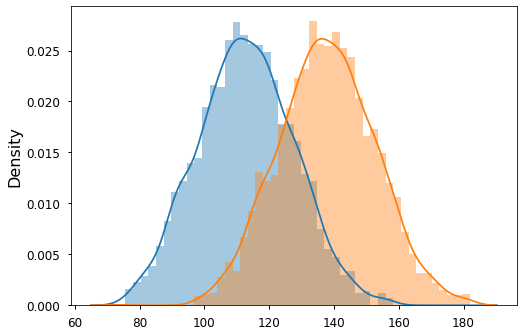

In [23]:
clf.fit(X,y,w)
emm.utils.weighted_hist(X[:m], w[:m])
emm.utils.weighted_hist(X[m:], w[m:])
plt.show()

In [8]:
X_test = np.array(target['feature']).reshape(-1,1)
y_test = np.array(target['Outcome']).reshape(-1,1)
clf.score(X_test,y_test)


0.787

In [9]:
LogisticRegression().set_params()

LogisticRegression()

In [10]:
histLoss0.mean

100